In [248]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from allen_v1dd.stimulus_analysis import analysis_tools as at
from allen_v1dd.stimulus_analysis.analysis_tools import iter_plane_groups
from allen_v1dd.stimulus_analysis.drifting_gratings import load_dg_xarray_from_h5

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
at.set_analysis_file("/Users/chase/Desktop/stimulus_analyses_v1.h5")
at.set_included_mice([409828])
at.set_included_columns([2, 3, 4, 5])

In [175]:
# Pull an example DG response
# M409828_13_2_29, DGF
filt = dict(mouse=409828, column=1, volume=3, plane=2)
roi = [17, 29]
for group in iter_plane_groups(filter=filt):
    dg = group["drifting_gratings_full"]
    pref_cond_idx = dg["pref_cond_index"][roi]
    dgf_response = load_dg_xarray_from_h5(dg, "trial_responses").sel(roi=roi)

dgf_response


<xarray.DataArray (roi: 2, direction: 12, spatial_frequency: 2, trial: 8)>
array([[[[0.00218762, 0.00215273, 0.00138571, 0.00175709, 0.00166495,
          0.        , 0.        ,        nan],
         [0.        , 0.00141895, 0.        , 0.00150893, 0.00150837,
          0.        , 0.        ,        nan]],

        [[0.        , 0.        , 0.00157995, 0.00109729, 0.        ,
          0.        , 0.        ,        nan],
         [0.        , 0.00173417, 0.00124848, 0.        , 0.00181549,
          0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        , 0.        , 0.        ,
          0.00125702, 0.        , 0.        ],
         [0.        , 0.00188438, 0.        , 0.00119906, 0.        ,
          0.00119265, 0.        , 0.        ]],

        [[0.00190826, 0.00365651, 0.        , 0.00111975, 0.00117198,
          0.        , 0.        ,        nan],
         [0.04294318, 0.        , 0.00200502, 0.03284587, 0.01153503,
          0.0173567 , 0.0231018 , 0.02177445]],

...

        [[0.00150358, 0.00141276, 0.00253793, 0.        , 0.        ,
          0.        , 0.00138944,        nan],
         [0.0012227 , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        ]],

        [[0.00163761, 0.00166681, 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.00187509],
         [0.        , 0.        , 0.00199863, 0.        , 0.        ,
          0.        , 0.        , 0.        ]],

        [[0.10081561, 0.11024106, 0.12205464, 0.02929235, 0.0740306 ,
          0.05872123, 0.06500498, 0.07712643],
         [0.01140942, 0.01885821, 0.        , 0.00234732, 0.001188  ,
          0.00156704, 0.00204081, 0.00153799]],

        [[0.00471805, 0.02557662, 0.04598923, 0.        , 0.00272014,
          0.01824659, 0.00123008, 0.00620776],
         [0.        , 0.00191248, 0.00136845, 0.00202585, 0.        ,
          0.        , 0.        , 0.00151489]]]])
Coordinates:
  * roi                (roi) int64 17 29
  * direction          (direction) int64 0 30 60 90 120 ... 210 240 270 300 330
  * spatial_frequency  (spatial_frequency) float64 0.04 0.08
  * trial              (trial) int64 0 1 2 3 4 5 6 7

In [149]:
def get_direction_tuning(trial_responses):
    # trial_responses is shape (..., n_directions, n_trials)
    return np.nanmean(trial_responses, axis=-1)
    # if svd:
    #     # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4724341/
    #     u, s, vh = np.linalg.svd(np.nan_to_num(roi_trial_resp, 0), full_matrices=False) # since we only care about first column of u
    #     return np.abs(u[:, 0])

In [209]:
pref_cond_idx[:, 1]

array([1, 0])

(2, 2, 12)


Text(0.5, 1.0, 'All ROI, pref SF')

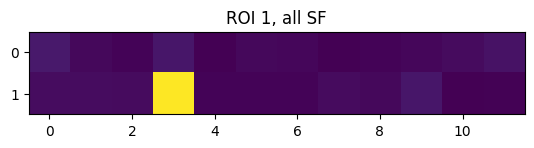

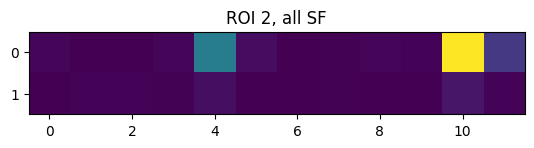

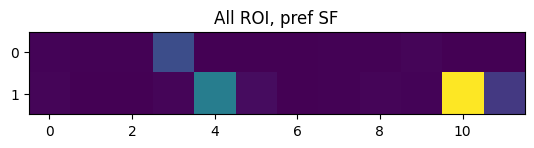

In [180]:
trial_responses = dgf_response.transpose("roi", "spatial_frequency", "direction", "trial").values
direction_tuning = get_direction_tuning(trial_responses) # shape (n_rois, n_sf, n_dir)
print(direction_tuning.shape)

plt.figure()
plt.imshow(direction_tuning.reshape(-1, 12)[:2])
plt.title("ROI 1, all SF")

plt.figure()
plt.imshow(direction_tuning.reshape(-1, 12)[2:])
plt.title("ROI 2, all SF")

plt.figure()
plt.imshow(direction_tuning.reshape(-1, 12)[2*np.arange(len(direction_tuning)) + pref_cond_idx[:, 1]])
plt.title("All ROI, pref SF")


In [214]:
n_rois, n_sf, n_dir, n_trials = trial_responses.shape
pref_trial_responses = np.empty(shape=(n_rois, n_dir, n_trials), dtype=float)

for roi in range(n_rois):
    pref_sf_idx = pref_cond_idx[roi, 1]
    pref_trial_responses[roi] = trial_responses[roi, pref_sf_idx]

pref_trial_responses.shape

(2, 12, 8)

In [252]:
def dg_selectivity_index(direction_tuning, metric="dsi"):
    # direction_tuning.shape = (..., n_directions)
    orig_shape = np.shape(direction_tuning)
    n_directions = orig_shape[-1]
    direction_tuning = np.reshape(direction_tuning, (-1, n_directions))
    n_tuning = len(direction_tuning)
    norm = np.sum(direction_tuning, axis=1)
    valid_mask = norm != 0

    si = np.full(n_tuning, np.nan, dtype=float)
    
    angles = np.arange(0, n_directions) / n_directions * 2*np.pi # angle (radians) corresponding to each direction (assume angles uniformly spaced between 0 and 360)
    if metric == "osi":
        angles *= 2
    si[valid_mask] = np.abs(np.dot(direction_tuning[valid_mask], np.exp(1j*angles)) / norm) # | sum R_theta * e^{-i theta} ||

    if len(orig_shape) == 1:
        si = si[0]
    else:
        si = si.reshape(orig_shape[:-1])

    return si

print(dg_selectivity_index(direction_tuning, metric="dsi"))

[[0.35515269 0.77031386]
 [0.41294476 0.22429583]]


In [236]:
def permutation_test(trial_responses, n_shuffles=10000, metric="dsi"):
    # trial_responses.shape is (..., n_directions, n_trials)
    # returns: tuple
    #   - met_true: True metric values
    #   - p_values: 
    #       (each of these is shape (...,))
    shape = trial_responses.shape
    first_dims = shape[:-2]
    direction_axis = len(shape) - 2
    
    tune_true = get_direction_tuning(trial_responses)
    met_true = dg_selectivity_index(tune_true, metric=metric)
    
    met_shuffled = np.empty((n_shuffles,) + first_dims, dtype=float)
    shuffled_trial_responses = np.copy(trial_responses) # copy once and shuffle this array

    for s in range(n_shuffles):
        np.apply_along_axis(np.random.shuffle, direction_axis, shuffled_trial_responses)
        tune_shuffled = get_direction_tuning(shuffled_trial_responses)
        met_shuffled[s] = dg_selectivity_index(tune_shuffled, metric=metric)

    p = np.mean(met_true < met_shuffled, axis=0)
    return met_true, p

met_true, p_values = permutation_test(trial_responses, metric="osi")
print(met_true)
print(p_values)

[[0.20190936 0.81589632]
 [0.90097812 0.59112133]]
[[0.2748 0.    ]
 [0.     0.0022]]


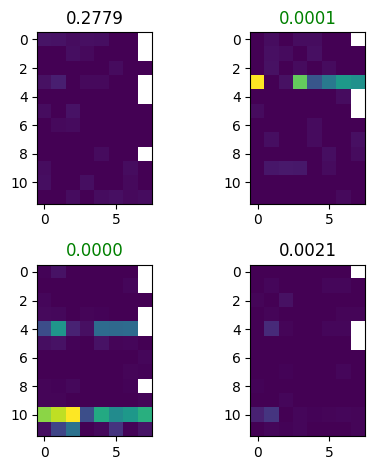

In [244]:
met_true, p_values = permutation_test(trial_responses, metric="osi")
nrows, ncols = met_true.shape
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, tight_layout=True)

for row in range(nrows):
    vmin = 0
    vmax = np.nanmax(trial_responses[row])
    for col in range(ncols):
        ax = axs[row, col]
        ax.imshow(trial_responses[row, col], vmin=vmin, vmax=vmax)
        ax.set_title(f"{p_values[row, col]:.4f}", color=("green" if pref_cond_idx[row, 1] == col else "black"))

# Now extrapolate this to all ROIs in a given session

In [ ]:
dgf_response

In [269]:
# Pull an example DG response
# M409828_13_2_29, DGF
filt = dict(mouse=409828, column=1, volume=3, plane=2)

for group in iter_plane_groups(filter=filt):
    inclusion = group["is_roi_valid"][()]
    dg = group["drifting_gratings_full"]
    pref_cond_idx = dg["pref_cond_index"][inclusion]
    trial_responses = load_dg_xarray_from_h5(dg, "trial_responses")[inclusion]
    trial_responses = trial_responses.transpose("roi", "spatial_frequency", "direction", "trial").values # transpose and convert to np.ndarray
    n_rois, n_sf, n_dir, n_trials = trial_responses.shape
    pref_trial_responses = np.empty(shape=(n_rois, n_dir, n_trials), dtype=float)

    for roi in range(n_rois):
        pref_sf_idx = pref_cond_idx[roi, 1]
        pref_trial_responses[roi] = trial_responses[roi, pref_sf_idx]

    is_resp = dg["is_responsive"][inclusion]
    osi_alt = dg["osi"][inclusion]
    # osi_true, osi_p_values = permutation_test(pref_trial_responses, metric="osi")

In [262]:
print("% sig OSI", (osi_p_values < 0.05).mean())
print("% resp", (is_resp).mean())
print("% resp & sig OSI", (is_resp & (osi_p_values < 0.05)).mean())

% sig OSI 0.2919254658385093
% resp 0.23395445134575568
% resp & sig OSI 0.16770186335403728


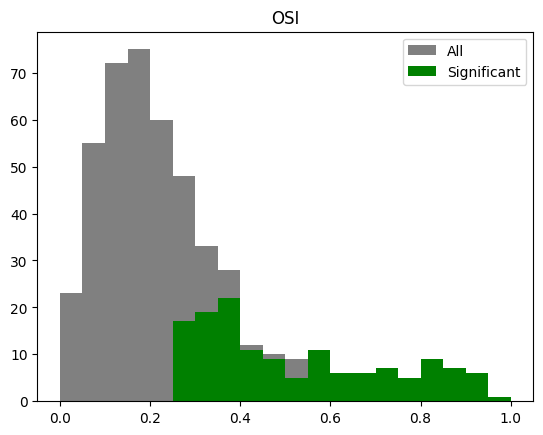

In [268]:
bins = np.arange(0, 1.05, 0.05)

plt.figure()
plt.title("OSI")
plt.hist(osi_true, bins, color="gray", label="All")
plt.hist(osi_true[osi_p_values < 0.05], bins, color="green", label="Significant")
plt.legend()

In [273]:
osi_true.shape, osi_alt.shape, p_values.shape

((483,), (483,), (2, 2))

(0.22114132532662964,
 0.9944748175229849,
 0.11991869688445111,
 1.0363933679391746)

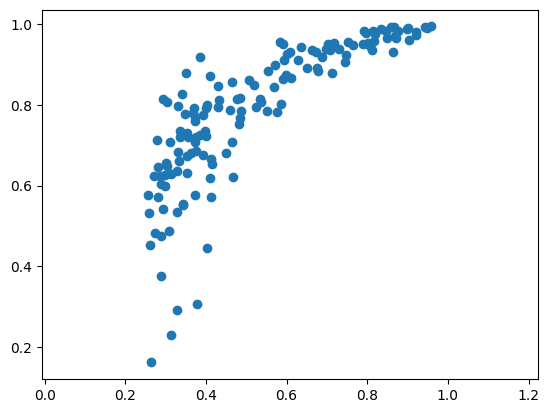

In [274]:
plt.figure()
plt.scatter(osi_true[osi_p_values < 0.05], osi_alt[osi_p_values < 0.05])
plt.axis("equal")

# Test DG analysis

In [279]:
from allen_v1dd.client import OPhysClient
from allen_v1dd.stimulus_analysis import DriftingGratings

In [276]:
client = OPhysClient("/Users/chase/Desktop/test_v1dd_data/")

In [278]:
session = client.load_ophys_session("M409828_11")

In [353]:
plane = session.get_planes()[4]
dg = DriftingGratings(session, plane, dg_type="full", quick_load=True)
dg.metrics

Loading DG-full response metrics for session M409828_11, plane 4...


,pref_response,pref_dir,pref_sf,pref_dir_idx,pref_sf_idx,pref_dir_mean,z_score,response_p,osi,gosi,...,pref_ori,chisq_response_p,null_dist_multi_mean,null_dist_multi_std,null_dist_single_mean,null_dist_single_std,osi_perm_test,osi_perm_test_p,dsi_perm_test,dsi_perm_test_p
0,0.008629,240.0,0.08,8.0,1.0,250.523301,27.148681,0.0000,0.788341,0.452885,...,60.0,0.50,0.000527,0.000298,0.000540,0.000864,0.452885,0.83,0.504987,0.53
1,0.001731,60.0,0.08,2.0,1.0,23.736548,3.785895,0.0013,0.623426,0.202989,...,60.0,0.16,0.000584,0.000303,0.000579,0.000856,0.202989,0.26,0.234859,0.14
2,0.001149,330.0,0.08,11.0,1.0,318.085289,2.704712,0.0058,0.358171,0.081148,...,150.0,0.75,0.000456,0.000256,0.000453,0.000732,0.081148,0.78,0.113129,0.59
3,0.001745,180.0,0.04,6.0,0.0,111.445465,4.440545,0.0000,0.417403,0.149574,...,0.0,0.01,0.000505,0.000279,0.000501,0.000792,0.149574,0.24,0.093657,0.48
4,0.001331,60.0,0.08,2.0,1.0,55.042921,3.853109,0.0005,0.600019,0.169810,...,60.0,0.64,0.000381,0.000247,0.000395,0.000711,0.169810,0.23,0.373011,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000602,0.000390,0.000596,0.001112,NaN,NaN,NaN,NaN
1304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.002366,0.001283,0.002381,0.003588,NaN,NaN,NaN,NaN
1305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.001600,0.000840,0.001608,0.002415,NaN,NaN,NaN,NaN
1306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.001200,0.000736,0.001202,0.002074,NaN,NaN,NaN,NaN


In [351]:
dg.metrics[["osi_perm_test", "osi_perm_test_p"]].values

array([[0.45288472, 0.84      ],
       [0.2029886 , 0.25      ],
       [0.08114816, 0.74      ],
       ...,
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan]])

In [319]:
dg.metrics[["osi_perm_test", "osi_perm_test_p"]].fillna(np.nan).values.astype(float)
# dg.metrics["osi_perm_test_2"] = np.nan
# dg.metrics.loc[dg.metrics.is_valid, "osi_perm_test_2"] = dg.metrics.osi_perm_test[dg.metrics.is_valid]
# dg.metrics

TypeError: float() argument must be a string or a real number, not 'NAType'

In [333]:
dg.metrics[["osi_perm_test", "osi_perm_test_p"]].values

TypeError: arg must be a list, tuple, 1-d array, or Series

In [337]:
dg.metrics.z_score.values.astype(float)

array([27.05912865,  3.7017608 ,  2.68951084, ...,         nan,
               nan,         nan])

In [344]:
dg.metrics[["z_score", "z_score"]].conver(pd.to_numeric, errors="coerce").values.astype(float)

TypeError: float() argument must be a string or a real number, not 'NAType'

In [346]:
np.all(["z_score" in dg.metrics.columns])

True

In [327]:
dg.metrics["osi_perm_test_2"] = np.nan
dg.metrics.convert_dtypes()

,pref_response,pref_dir,pref_sf,pref_dir_idx,pref_sf_idx,pref_dir_mean,z_score,response_p,osi,gosi,...,chisq_response_p,null_dist_multi_mean,null_dist_multi_std,null_dist_single_mean,null_dist_single_std,osi_perm_test,osi_perm_test_p,dsi_perm_test,dsi_perm_test_p,osi_perm_test_2
0,0.008629,240,0.08,8,1,250.523301,27.059129,0.0,0.788341,0.452885,...,0.53,0.000517,0.0003,0.000533,0.000856,0.452885,0.79,0.504987,0.57,<NA>
1,0.001731,60,0.08,2,1,23.736548,3.701761,0.0017,0.623426,0.202989,...,0.13,0.000583,0.00031,0.000578,0.000859,0.202989,0.25,0.234859,0.16,<NA>
2,0.001149,330,0.08,11,1,318.085289,2.689511,0.0081,0.358171,0.081148,...,0.68,0.000452,0.000259,0.000453,0.000734,0.081148,0.67,0.113129,0.53,<NA>
3,0.001745,180,0.04,6,0,111.445465,4.404941,0.0001,0.417403,0.149574,...,0.01,0.000511,0.00028,0.000517,0.000797,0.149574,0.22,0.093657,0.49,<NA>
4,0.001331,60,0.08,2,1,55.042921,3.788725,0.0004,0.600019,0.16981,...,0.46,0.000385,0.00025,0.000405,0.000724,0.16981,0.27,0.373011,0.0,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1303,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,0.000609,0.000395,0.00062,0.00113,<NA>,<NA>,<NA>,<NA>,<NA>
1304,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,0.00239,0.001268,0.002441,0.003613,<NA>,<NA>,<NA>,<NA>,<NA>
1305,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,0.00158,0.000843,0.001613,0.002422,<NA>,<NA>,<NA>,<NA>,<NA>
1306,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,0.001189,0.000733,0.001221,0.002095,<NA>,<NA>,<NA>,<NA>,<NA>


In [349]:
metrics = dg.metrics
def get_met_col(col, default_val=0, dtype=float):
    if type(col) is str:
        if col in metrics.columns:
            return metrics[col].values.astype(dtype)
    else:
        return np.vstack([metrics[c].values.astype(dtype) for c in col]).astype(dtype)

    return np.full(len(metrics), default_val, dtype=dtype)

col = "osi_perm_test"
get_met_col([col, f"{col}_p"], default_val=np.nan, dtype=float).shape

(2, 1308)